In [1]:
import jax
from jax import numpy as np
from jax import scipy as sp
from jax import random

import numpy as onp
from numpy.polynomial.hermite import hermgauss

import paragami

# GMM libraries
import bnpgmm_runjingdev.gmm_clustering_lib as gmm_lib
import bnpgmm_runjingdev.utils_lib as utils_lib
import bnpgmm_runjingdev.gmm_optimization_lib as gmm_optim_lib
from bnpgmm_runjingdev import gmm_posterior_quantities_lib

# BNP libraries
from bnpmodeling_runjingdev.sensitivity_lib import HyperparameterSensitivityLinearApproximation
from bnpmodeling_runjingdev import result_loading_utils, influence_lib
import bnpmodeling_runjingdev.functional_sensitivity_lib as func_sens_lib

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm

from sklearn.decomposition import PCA

from copy import deepcopy

import time

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


# Load data

We load and plot the iris dataset

In [2]:
# load iris data
dataset_name = 'iris'
iris_obs, iris_species = utils_lib.load_iris_data()
dim = iris_obs.shape[1]
n_obs = len(iris_species)

iris_obs = np.array(iris_obs)

Text(0, 0.5, 'PC2')

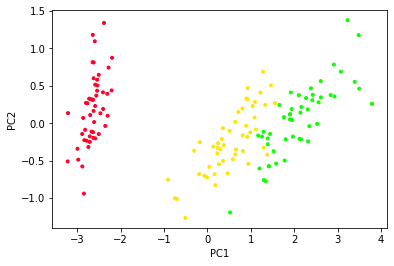

In [3]:
# run PCA
pca_fit = PCA()
pca_fit.fit(iris_obs)
pc_iris_obs = pca_fit.transform(iris_obs)

# plot
cmap = cm.get_cmap(name='gist_rainbow')
colors1 = [cmap(k * 50) for k in range(30)]

fig1 = plt.figure(1)
fig = fig1.add_subplot(111)
utils_lib.plot_clusters(pc_iris_obs[:, 0], pc_iris_obs[:, 1], iris_species, colors1, fig)
fig.set_xlabel('PC1')
fig.set_ylabel('PC2')


# file paths

In [4]:
out_folder = '../fits/'
out_filename = 'iris_fit'

In [5]:
alpha0 = 6.0

# Load initial fit

In [6]:
init_fit_file = out_folder + out_filename + '_alpha' + str(alpha0) + '.npz'
print(init_fit_file)

../fits/iris_fit_alpha6.0.npz


In [7]:
vb_opt_dict, vb_params_paragami, init_fit_meta_data = \
            paragami.load_folded(init_fit_file)
        
vb_opt = vb_params_paragami.flatten(vb_opt_dict, free = True)    

In [8]:
k_approx = vb_opt_dict['cluster_params']['centroids'].shape[0]
print(k_approx)

15


### Load other meta data

In [9]:
# gauss-hermite parameters
gh_deg = int(init_fit_meta_data['gh_deg'])
gh_loc, gh_weights = hermgauss(gh_deg)

gh_loc = np.array(gh_loc)
gh_weights = np.array(gh_weights)
    
# load prior parameters
prior_params_dict, prior_params_paragami = gmm_lib.get_default_prior_params(dim)

# set initial alpha
assert alpha0 == init_fit_meta_data['dp_prior_alpha']
prior_params_dict['dp_prior_alpha'] = alpha0

print(prior_params_dict)

{'dp_prior_alpha': 6.0, 'prior_centroid_mean': DeviceArray([0.], dtype=float64), 'prior_lambda': DeviceArray([1.], dtype=float64), 'prior_wishart_df': DeviceArray([10.], dtype=float64), 'prior_wishart_rate': DeviceArray([[1., 0., 0., 0.],
             [0., 1., 0., 0.],
             [0., 0., 1., 0.],
             [0., 0., 0., 1.]], dtype=float64)}


In [10]:
# the objective 
kl = gmm_lib.get_kl(iris_obs, vb_opt_dict, prior_params_dict, gh_loc, gh_weights)

In [11]:
kl - init_fit_meta_data['final_kl']

DeviceArray(0., dtype=float64)

### Optimal ez

In [12]:
e_z_opt = gmm_posterior_quantities_lib.get_optimal_z_from_vb_dict(iris_obs,
                               vb_opt_dict,
                               gh_loc,
                               gh_weights,
                               use_bnp_prior = True)

### Check results

In [13]:
def plot_results_from_vb_params_dict(pca_fit, vb_params_dict, e_z, fig): 
    # we plot in PCA space
    bnp_centroids_pc, bnp_cluster_covs_pc = \
        utils_lib.transform_params_to_pc_space(pca_fit, vb_params_dict['cluster_params']['centroids'], 
                                               np.linalg.inv(vb_params_dict['cluster_params']['cluster_info']))
    
    bnp_clusters = np.argmax(e_z, axis = 1)
    
    cmap = cm.get_cmap(name='gist_rainbow')
    colors1 = [cmap(k * 50) for k in range(30)]
    
    utils_lib.plot_clusters(pc_iris_obs[:, 0], pc_iris_obs[:, 1], bnp_clusters, \
                  colors1, fig, \
                  centroids = bnp_centroids_pc[np.unique(bnp_clusters), :], 
                cov = bnp_cluster_covs_pc[np.unique(bnp_clusters), :, :])


In [14]:
bnp_centroids_pc, bnp_cluster_covs_pc = \
        utils_lib.transform_params_to_pc_space(pca_fit, vb_opt_dict['cluster_params']['centroids'], 
                                               np.linalg.inv(vb_opt_dict['cluster_params']['cluster_info']))

In [15]:
bnp_centroids_pc.shape

(15, 4)

### Plot centroids

Text(0, 0.5, 'PC2')

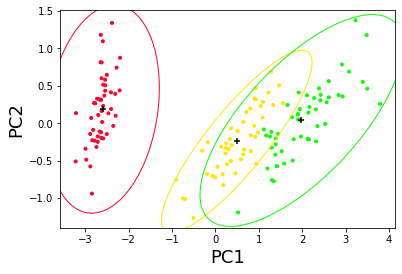

In [16]:
fig1 = plt.figure(1)
fig = fig1.add_subplot(111)

plot_results_from_vb_params_dict(pca_fit, vb_opt_dict, e_z_opt, fig)
fig.set_xlabel('PC1', fontsize = 18)
fig.set_ylabel('PC2', fontsize = 18)


In [17]:
def get_e_num_obs_per_cluster(vb_params_dict): 
    ez = gmm_posterior_quantities_lib.get_optimal_z_from_vb_dict(iris_obs,
                               vb_params_dict,
                               gh_loc,
                               gh_weights,
                               use_bnp_prior = True)
    return ez.sum(0)

In [18]:
e_num_obs_per_cluster = get_e_num_obs_per_cluster(vb_opt_dict)
mixture_weights = gmm_posterior_quantities_lib.get_e_mixture_weights_from_vb_dict(vb_opt_dict, gh_loc, gh_weights)

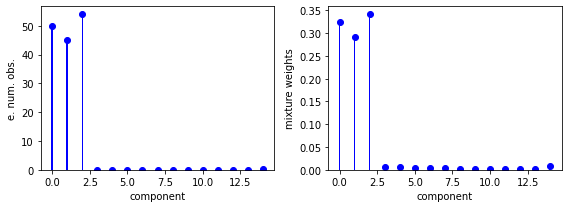

In [19]:
fig, axarr = plt.subplots(1, 2, figsize = (8, 3))

result_loading_utils._plot_weights(e_num_obs_per_cluster, 
                                   axarr[0])

result_loading_utils._plot_weights(mixture_weights, 
                                   axarr[1])


axarr[0].set_ylabel('e. num. obs.')
axarr[1].set_ylabel('mixture weights')
    
fig.tight_layout()

# Define sensitivity class

In [20]:
def objective_fun(vb_params_free, epsilon): 
    
    # NOTE! epsilon doesn't actual enter 
    # into this function. 
    
    # since the initial fit is at epsilon = 0, 
    # we just return the actual KL
    
    # we really just need the hessian wrt to vb free parameters ... 
    
    vb_params_dict = vb_params_paragami.fold(vb_params_free, 
                                             free = True)
        
    return gmm_lib.get_kl(iris_obs, 
                          vb_params_dict,
                          prior_params_dict,
                          gh_loc, gh_weights).squeeze()

In [21]:
vb_sens = HyperparameterSensitivityLinearApproximation(objective_fun,
                                                        vb_opt,
                                                        0.)

Compiling hessian solver ...
Hessian solver compile time: 58.3649sec

Compiling cross hessian...
Cross-hessian compile time: 0.670593sec

LR sensitivity time: 0.0187998sec



# Influence functions

In [22]:
logit_v_grid = np.linspace(-8, 8, 500)

In [23]:
# class to get influence functions
influence_operator = influence_lib.InfluenceOperator(vb_opt, 
                           vb_params_paragami, 
                           vb_sens.hessian_solver,
                           prior_params_dict['dp_prior_alpha'], 
                           stick_key = 'stick_params')


In [24]:
def get_influence(g): 
    print('computing gradient ...')
    t0 = time.time()
    get_grad_g = jax.jacobian(g, argnums = 0)
    grad_g = get_grad_g(vb_opt).block_until_ready()
    grad_g_time = time.time() - t0  
    print('Elapsed: {:.03f}sec'.format(grad_g_time))
    
    # get influence function
    print('inverting Hessian (twice) ...')
    t0 = time.time()
    
    # get influence function as defined
    influence_grid, grad_g_hess_inv = \
        influence_operator.get_influence(logit_v_grid, 
                                         grad_g)
    
    
    # this is influence times the prior
    influence_grid_x_prior, _ = \
        influence_operator.get_influence(logit_v_grid, 
                                         grad_g, 
                                         normalize_by_prior = False)
    
    hess_inv_time = time.time() - t0
    print('Elapsed: {:.03f}sec'.format(hess_inv_time))
    
        
    return influence_grid, influence_grid_x_prior, grad_g_hess_inv, grad_g_time, hess_inv_time


### Influence function on mixture weights

In [25]:
def get_mixture_weight_k(vb_free, k = 0): 
    vb_params_dict = vb_params_paragami.fold(vb_free, free = True)
    
    return gmm_posterior_quantities_lib.get_e_mixture_weights_from_vb_dict(vb_params_dict,
                                                                           gh_loc,
                                                                           gh_weights)[k]

In [26]:
e_num_ind_results = dict()
for k in range(4): 
    print('##############')
    print('Computing influence for k = {}'.format(k))
    print('##############')
    influence_grid, influence_grid_x_prior, ghess = get_influence(lambda x : get_mixture_weight_k(x, k))[0:3]
    e_num_ind_results['influence_grid{}'.format(k)] = influence_grid
    e_num_ind_results['influence_grid_x_prior{}'.format(k)] = influence_grid_x_prior
    e_num_ind_results['ghess{}'.format(k)] = ghess
    print('\n')

##############
Computing influence for k = 0
##############
computing gradient ...
Elapsed: 1.994sec
inverting Hessian (twice) ...
Elapsed: 5.906sec


##############
Computing influence for k = 1
##############
computing gradient ...
Elapsed: 0.940sec
inverting Hessian (twice) ...
Elapsed: 2.613sec


##############
Computing influence for k = 2
##############
computing gradient ...
Elapsed: 1.144sec
inverting Hessian (twice) ...
Elapsed: 2.607sec


##############
Computing influence for k = 3
##############
computing gradient ...
Elapsed: 0.937sec
inverting Hessian (twice) ...
Elapsed: 2.626sec




In [27]:
# the prior (for plotting)
def p0(logit_v): 
    return np.exp(influence_lib.get_log_logitstick_prior(logit_v, alpha0))

In [28]:
def get_wc_log_phi_grid(influence_grid): 
    # returns log_phi at points logit_v_grid
    # just for plotting
    
    worst_case = influence_lib.WorstCasePerturbation(influence_fun = None, 
                                                    logit_v_grid = logit_v_grid, 
                                                    delta = 1.,
                                                    cached_influence_grid = influence_grid)

    return worst_case.log_phi(logit_v_grid), worst_case.change_points

In [29]:
def plot_influence_grid(influence_grid, influence_grid_x_prior, ax): 
    
    # plot y = 0 line
    for i in range(4): 
        ax[i].axhline(0, color = 'black')
    
    # plot influence function
    ax[0].plot(logit_v_grid, influence_grid, color = '#43a2ca')
    
    # plot prior
    ax[1].plot(logit_v_grid, p0(logit_v_grid), 
                  color = '#7bccc4')
    
    # plot influence x prior
    ax[2].plot(logit_v_grid, influence_grid_x_prior, color = '#0868ac')
    
    # plot l-inf worst-case perturbation
    wc_log_phi, change_points = get_wc_log_phi_grid(influence_grid)
    ax[3].plot(logit_v_grid, wc_log_phi, color = 'grey')
    
    # plot change points 
#     for x in change_points: 
#         ax[2].axvline(x, color = 'grey', linestyle = '--')
    
    ax[0].set_ylabel('influence')
    ax[1].set_ylabel('prior')
    ax[2].set_ylabel('influence x prior')
    ax[3].set_ylabel('worst-case log phi')

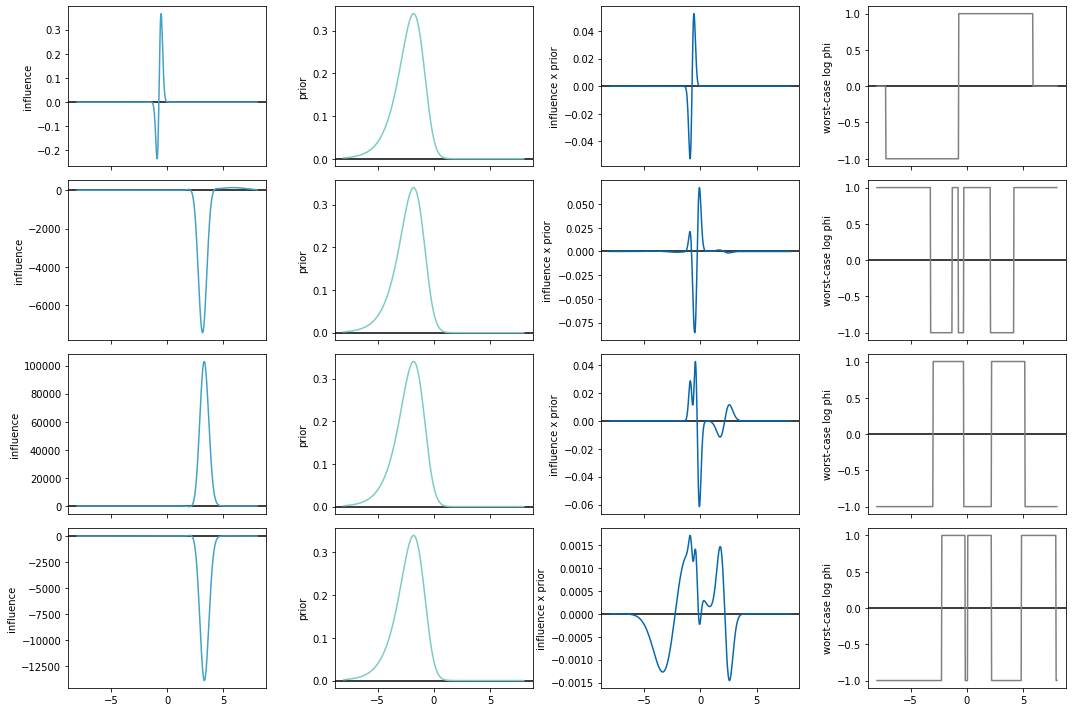

In [30]:
fig, axarr = plt.subplots(4, 4, figsize = (15, 10),  sharex = True) 
for k in range(4): 
    plot_influence_grid(e_num_ind_results['influence_grid{}'.format(k)],
                        e_num_ind_results['influence_grid_x_prior{}'.format(k)],
                        axarr[k])
fig.tight_layout()

### Influence function on expected number of clusters

In [31]:
prng_key = jax.random.PRNGKey(223)
threshold = 0

@jax.jit
def get_n_clusters_insample(vb_free):
    
    vb_params_dict = vb_params_paragami.fold(vb_free, free = True)
    
    return gmm_posterior_quantities_lib.get_e_num_clusters_from_vb_dict(iris_obs,
                                                    vb_params_dict,
                                                    gh_loc, gh_weights,
                                                    threshold = threshold,
                                                    n_samples = 10000, 
                                                    prng_key = prng_key)
@jax.jit
def get_n_clusters_pred(vb_free):
    
    vb_params_dict = vb_params_paragami.fold(vb_free, free = True)
    
    return gmm_posterior_quantities_lib.get_e_num_pred_clusters_from_vb_dict(vb_params_dict,
                                                               n_obs = iris_obs.shape[0],
                                                               threshold = threshold,
                                                               prng_key = prng_key)

In [32]:
infl_num_clust, infl_x_prior_num_clust, ghess_num_clust = \
    get_influence(get_n_clusters_insample)[0:3]
infl_num_clust_pred, infl_x_prior_num_clust_pred, ghess_num_clust_pred = \
    get_influence(get_n_clusters_pred)[0:3]

computing gradient ...
Elapsed: 8.208sec
inverting Hessian (twice) ...
Elapsed: 2.674sec
computing gradient ...
Elapsed: 1.985sec
inverting Hessian (twice) ...
Elapsed: 2.650sec


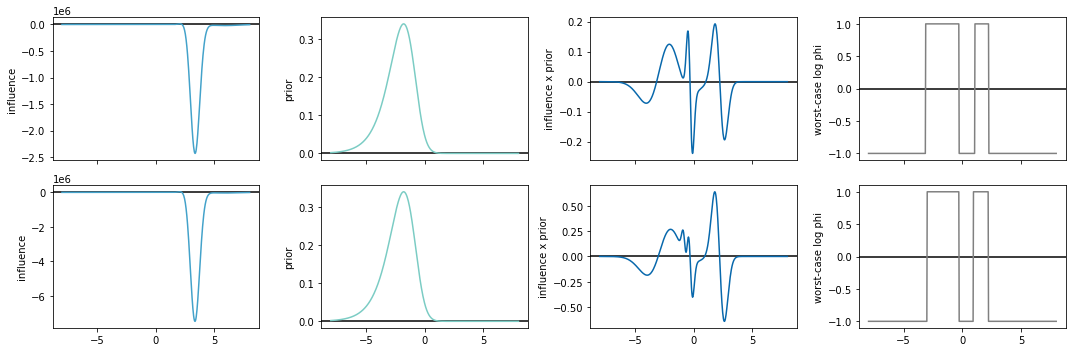

In [33]:
fig, axarr = plt.subplots(2, 4, figsize = (15, 5),  sharex = True) 

plot_influence_grid(infl_num_clust,
                    infl_x_prior_num_clust,
                    axarr[0])

plot_influence_grid(infl_num_clust_pred,
                    infl_x_prior_num_clust_pred,
                    axarr[1])


fig.tight_layout()

# Define step bumps

In [34]:
mu_vec = np.arange(-6, 7)
print(len(mu_vec))

13


In [35]:
def step_bump(x, mu_indx):    
    return (x > mu_vec[mu_indx]) & (x <= mu_vec[mu_indx+1])


In [36]:
# analytic expectations since we are just perturbing with step functions

def e_step_bump(means, infos, mu_indx): 
    cdf1 = sp.stats.norm.cdf(mu_vec[mu_indx+1], loc = means, scale = 1 / np.sqrt(infos))
    cdf2 = sp.stats.norm.cdf(mu_vec[mu_indx], loc = means, scale = 1 / np.sqrt(infos))
    
    return (cdf1 - cdf2).sum()


#  Load refitted vb parameters

In [37]:
num_mus = 12

In [38]:
def _load_refit_results_for_mu(mu_indx): 
    match_crit = out_filename + '_inflbump_mu{}_eps'.format(mu_indx) + '\d+.npz'
    
    # load free parameters
    vb_refit_list, epsilon_vec, meta_data_list = \
        result_loading_utils.load_refit_files_epsilon(out_folder, match_crit)
    
    # get mu
    mus = result_loading_utils._load_meta_data_from_list(meta_data_list, 'mu')
    mu = np.unique(mus)
    assert len(mu) == 1
    
    # check prior parameter matches
    assert np.all(result_loading_utils._load_meta_data_from_list(meta_data_list, 'dp_prior_alpha') == \
                  alpha0)
    
    return vb_refit_list, epsilon_vec, mu

In [39]:
def load_all_refit_results(): 
    
    mu_vec = onp.zeros(num_mus)
    
    for mu_indx in range(num_mus): 
        vb_refit_list, _epsilon_vec, mu= _load_refit_results_for_mu(mu_indx)
        
        if mu_indx == 0: 
            epsilon_vec = deepcopy(_epsilon_vec)
            vb_refit_array = onp.zeros((num_mus, len(epsilon_vec), vb_refit_list.shape[-1]))
            
        assert np.all(epsilon_vec == _epsilon_vec)
            
        vb_refit_array[mu_indx] = vb_refit_list
        mu_vec[mu_indx] = mu
        
    return np.array(vb_refit_array), epsilon_vec, mu_vec

In [40]:
vb_refit_array, epsilon_vec, _mu_vec = load_all_refit_results()
print(_mu_vec)

[-6. -5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.]


In [41]:
mu_vec = np.concatenate((_mu_vec, np.array([_mu_vec[-1] + 1])))
print(mu_vec)

[-6. -5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.  6.]


### For plotting, define step bumps

In [42]:
def step_bump(x, mu_indx):    
    return (x > mu_vec[mu_indx]) & (x <= mu_vec[mu_indx+1])


In [43]:
# analytic expectations since we are just perturbing with step functions

def e_step_bump(means, infos, mu_indx): 
    cdf1 = sp.stats.norm.cdf(mu_vec[mu_indx+1], loc = means, scale = 1 / np.sqrt(infos))
    cdf2 = sp.stats.norm.cdf(mu_vec[mu_indx], loc = means, scale = 1 / np.sqrt(infos))
    
    return (cdf1 - cdf2).sum()


# Function to compute posterior statistic on all refits

In [44]:
def get_refit_g_array(g): 
    
    refit_g_array = onp.zeros(vb_refit_array.shape[0:2])
    
    for i in range(refit_g_array.shape[0]): 
        for j in range(refit_g_array.shape[1]): 
            
            refit_g_array[i, j] = g(vb_refit_array[i, j])
        
    return refit_g_array

# Compute cross-hessians

One cross-hessian for each mu

In [45]:
cross_hess_list = []

for i in range(len(mu_vec) - 1): 
    # compute linear response stuff
    f_obj = func_sens_lib.FunctionalPerturbationObjective(None, 
                                                          vb_params_paragami, 
                                                          e_log_phi = lambda x,y : e_step_bump(x,y,i), 
                                                          gh_loc = gh_loc, 
                                                          gh_weights = gh_weights, 
                                                          stick_key = 'stick_params')

    vb_sens._set_cross_hess_and_solve(f_obj.hyper_par_objective_fun)
    
    cross_hess_list.append(vb_sens.cross_hess.squeeze())


Compiling cross hessian...
Cross-hessian compile time: 0.59401sec

LR sensitivity time: 0.0180535sec

Compiling cross hessian...
Cross-hessian compile time: 0.493721sec

LR sensitivity time: 0.0173686sec

Compiling cross hessian...
Cross-hessian compile time: 0.488967sec

LR sensitivity time: 0.0185785sec

Compiling cross hessian...
Cross-hessian compile time: 0.488954sec

LR sensitivity time: 0.0186307sec

Compiling cross hessian...
Cross-hessian compile time: 0.48853sec

LR sensitivity time: 0.0172386sec

Compiling cross hessian...
Cross-hessian compile time: 0.489561sec

LR sensitivity time: 0.015919sec

Compiling cross hessian...
Cross-hessian compile time: 0.819955sec

LR sensitivity time: 0.0163109sec

Compiling cross hessian...
Cross-hessian compile time: 0.49399sec

LR sensitivity time: 0.0140171sec

Compiling cross hessian...
Cross-hessian compile time: 0.498055sec

LR sensitivity time: 0.0147181sec

Compiling cross hessian...
Cross-hessian compile time: 0.49931sec

LR sensiti

# Function to get LR derivatives for a given posterior statistic

In [46]:
def get_lr_results(g, ghess, epsilon_vec):
    lr_g_array = onp.zeros((len(mu_vec) - 1, len(epsilon_vec)))

    for i in range(len(mu_vec) - 1): 

        # derivative of posterior quantity wrt hyper parameter
        # note the negative sign!
        # the "cross-hessian" is computed using the perturbation to the KL!
        # to get the derivative, we need the inner-product between 
        # the influence operator and the perturbation to the **ELBO**
        # see theorem 2 in giordano
        dg_dhyper = np.dot(ghess, -cross_hess_list[i])
        
        # get lr results
        lr_g_array[i, :] = g(vb_opt) + dg_dhyper * epsilon_vec
    
    return lr_g_array


# Plot results

In [47]:
def plot_results(g, ghess, influence_x_prior_grid): 
    
    # get array of posterior values
    refit_g_array = get_refit_g_array(g)

    # lr results
    lr_g_array = get_lr_results(g, 
                                ghess, 
                                epsilon_vec)
    
    diff_refit = refit_g_array - refit_g_array[:, 0:1]
    diff_lr = lr_g_array - lr_g_array[:, 0:1]
    
    max_diff = max(np.abs(diff_refit).max(), 
                   np.abs(diff_lr).max())
    
    
    for i in range(12): 
        
        fig, ax = plt.subplots(1, 4, figsize = (14, 3.5))
        
        ###################
        # plot prior x influence function 
        ###################
        ax[0].plot(logit_v_grid, influence_x_prior_grid)
        # plot y = 0
        ax[0].axhline(0, color = 'black')
                
        # overlay bump
        ax[0].axvline(mu_vec[i], color = 'grey', linestyle = '--')
        ax[0].axvline(mu_vec[i+1], color = 'grey', linestyle = '--')
        
        ax[0].set_xlabel('logit-sticks')

        ###################
        # plot perturbed prior 
        ###################
        # compute perturbed prior
        prior_perturbation = func_sens_lib.PriorPerturbation(
                                    alpha0 = alpha0,
                                    log_phi = lambda x : step_bump(x, i), 
                                    logit_v_ub = 10, 
                                    logit_v_lb = -10)
        
        ax[1].set_title('priors in logit space')
        ax[1].plot(logit_v_grid,
                   np.exp(prior_perturbation.get_log_p0_logit(logit_v_grid)), 
                   color = 'lightblue', 
                   label = 'p0')
        
        ax[1].plot(logit_v_grid, 
                   np.exp(prior_perturbation.get_log_pc_logit(logit_v_grid)), 
                   color = 'blue', 
                   label = 'p1')
        ax[1].set_xlabel('logit-sticks')
        ax[1].set_ylabel('p')


        v_grid = sp.special.expit(logit_v_grid)
        ax[2].set_title('priors in constrained space')
        ax[2].plot(v_grid, 
                   np.exp(prior_perturbation.get_log_p0(v_grid)),
                   color = 'lightblue', 
                   label = 'p0')
        ax[2].plot(v_grid, 
                   np.exp(prior_perturbation.get_log_pc(v_grid)), 
                   color = 'blue', 
                   label = 'p1')
        ax[2].set_xlabel('sticks')
        ax[2].set_ylabel('p')


        ax[2].legend()

        
        ###################
        # plot posterior statistic 
        ###################                        
        # plot refit results
        ax[3].plot(epsilon_vec,
                      refit_g_array[i, :] - refit_g_array[i, 0], 
                      '-o', 
                      label = 'refit')

        # plot lr results
        ax[3].plot(epsilon_vec, 
                      lr_g_array[i, :] - lr_g_array[i, 0], 
                      '-o', 
                      label = 'lr')
        
        # make y-axes all the same
        ax[3].set_ylim((-max_diff, max_diff))
        
        ax[3].set_xlabel('epsilon')
        ax[3].axhline(0, color = 'black')
        
        ax[3].legend()
        ax[3].set_ylabel('g(pert) - g(init)')
    
        fig.tight_layout()

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 1.613749e-02
  warnings.warn(
/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 5.602147e-02
  warnings.warn(
/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 6.110584e-02
  warnings.warn(
/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 2.922261e-01
  warnings.warn(
/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter 

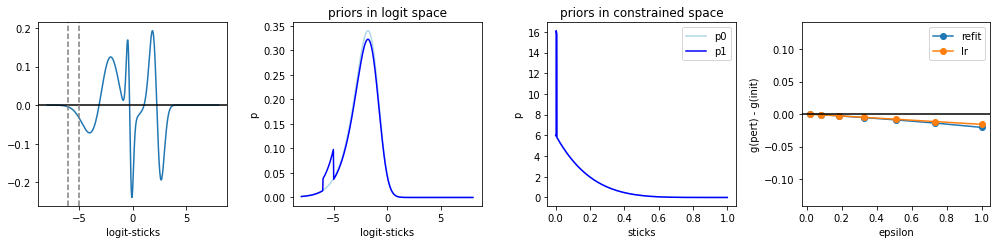

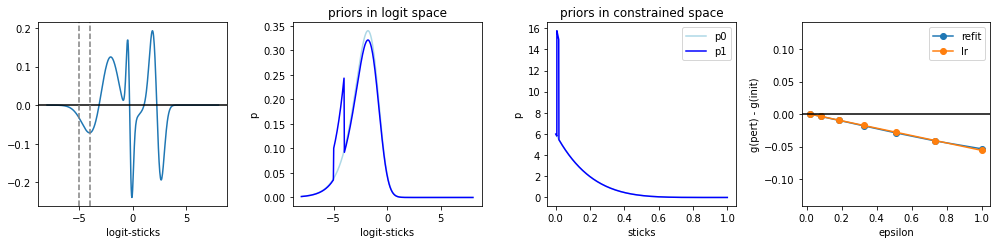

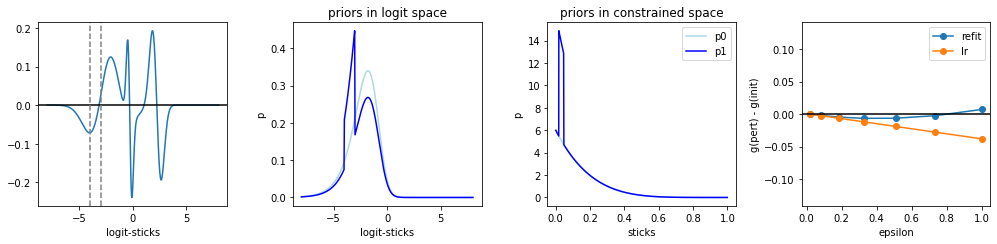

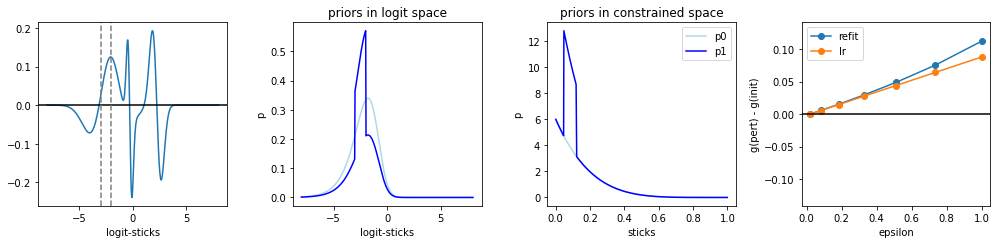

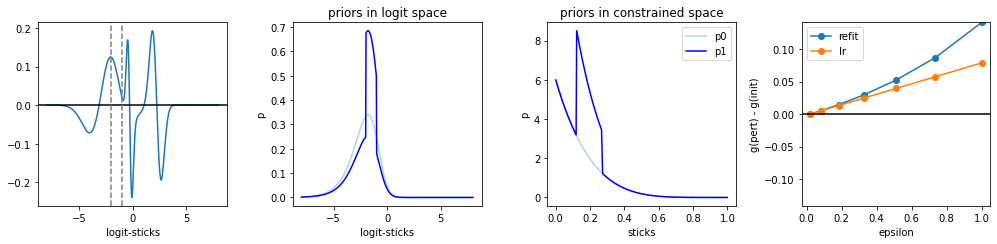

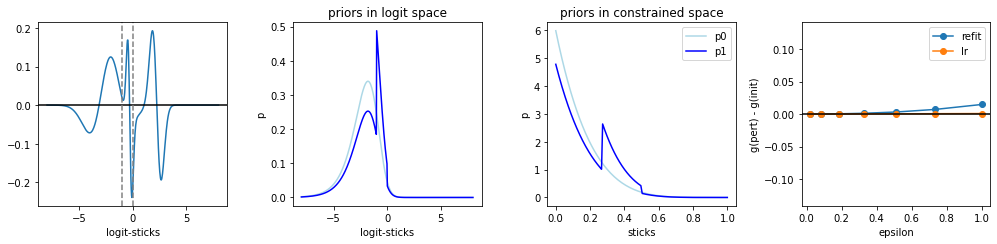

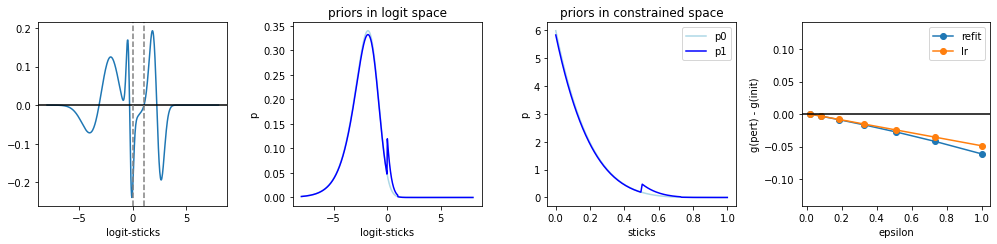

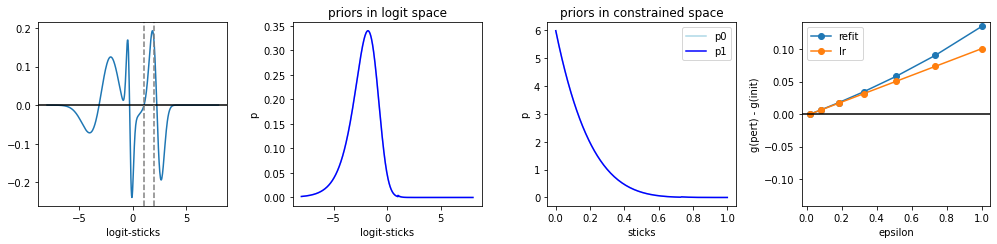

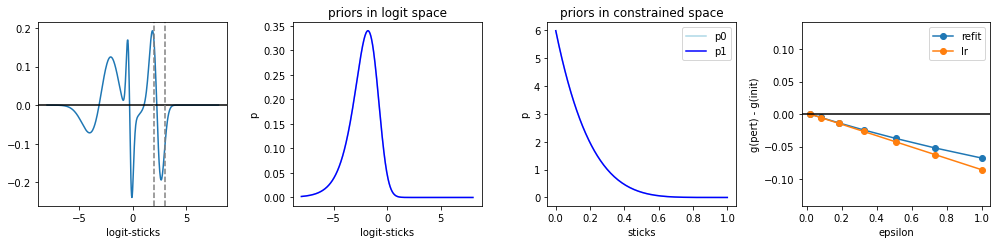

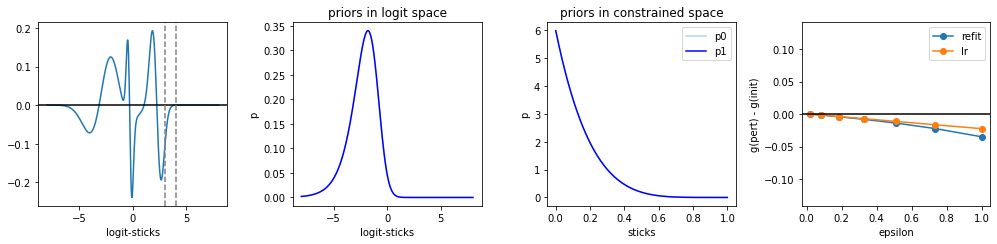

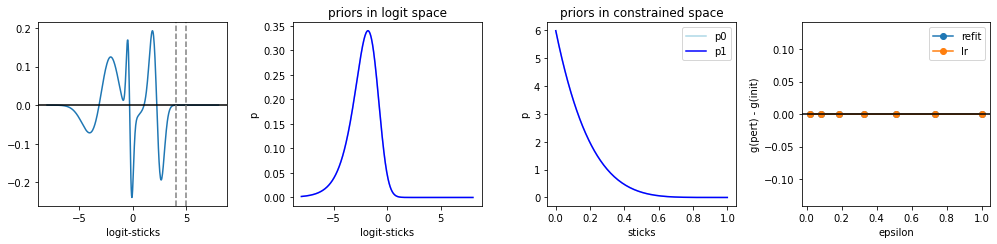

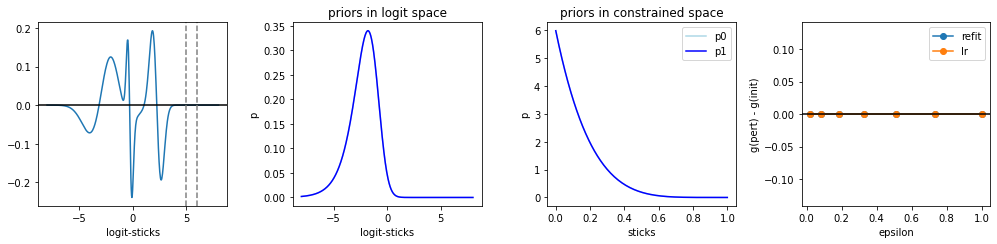

In [48]:
plot_results(get_n_clusters_insample,
                 ghess_num_clust, 
                 infl_x_prior_num_clust)

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 1.613749e-02
  warnings.warn(
/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 5.602147e-02
  warnings.warn(
/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 6.110584e-02
  warnings.warn(
/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 2.922261e-01
  warnings.warn(
/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter 

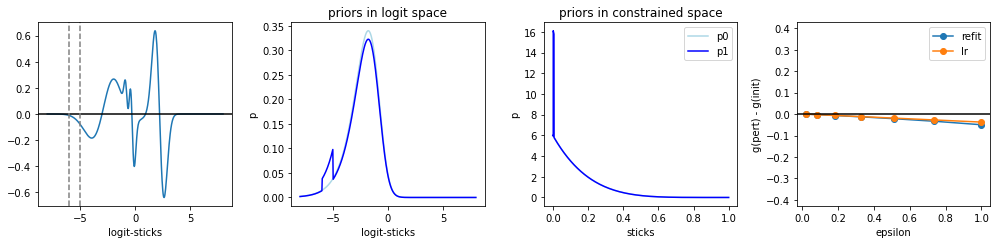

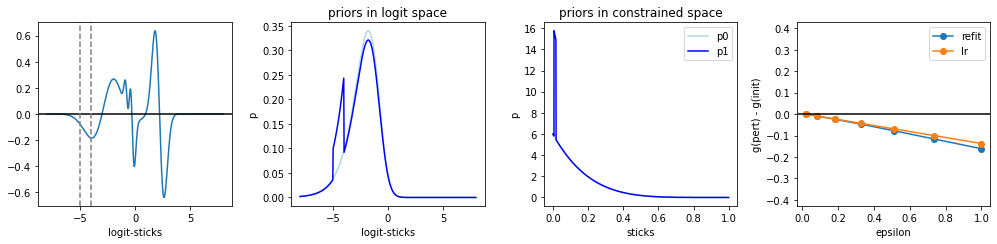

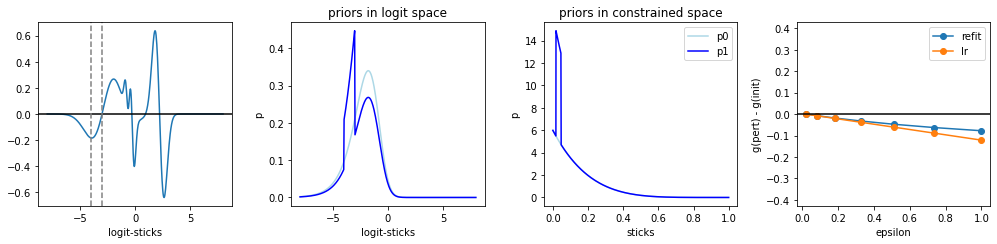

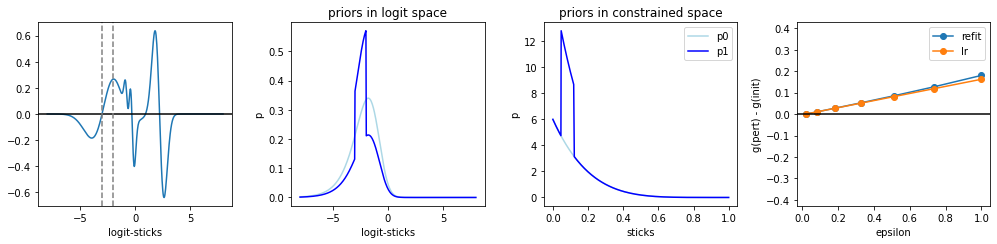

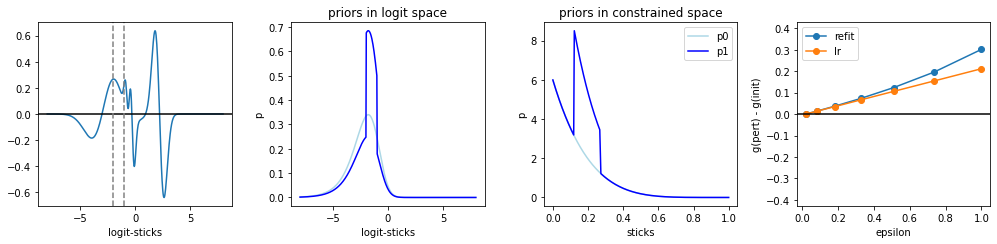

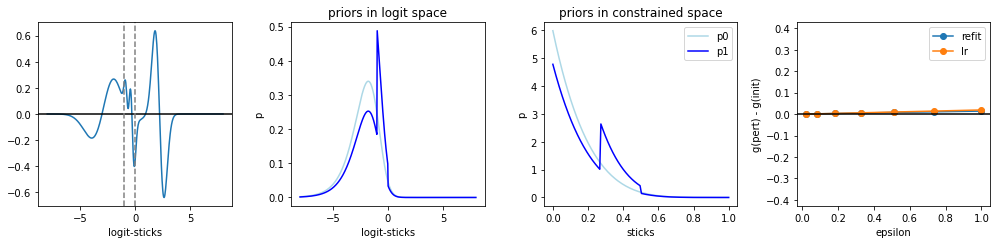

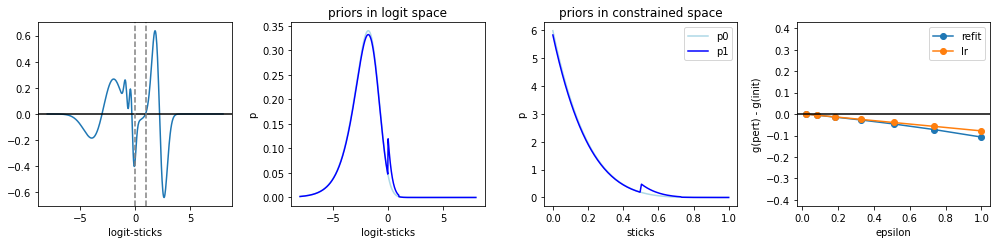

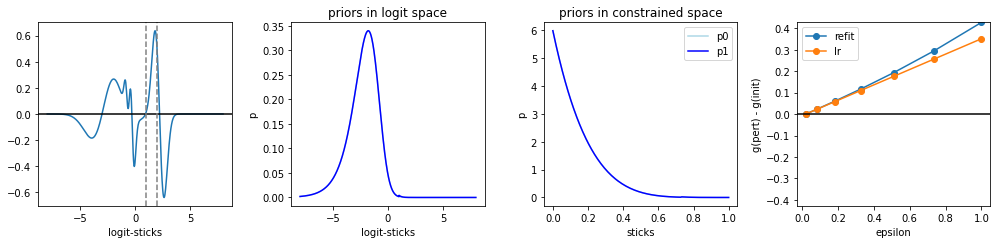

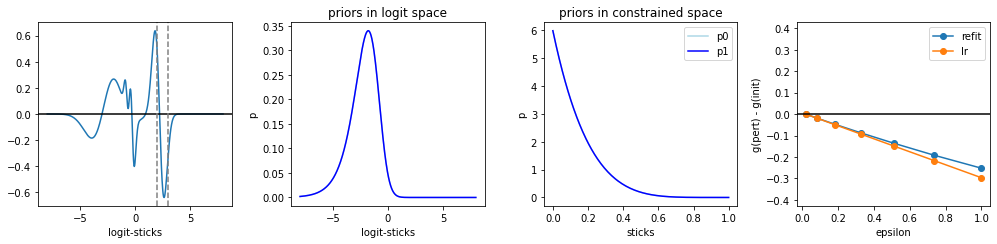

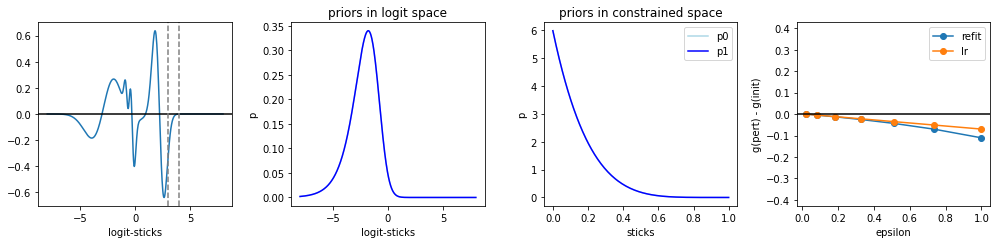

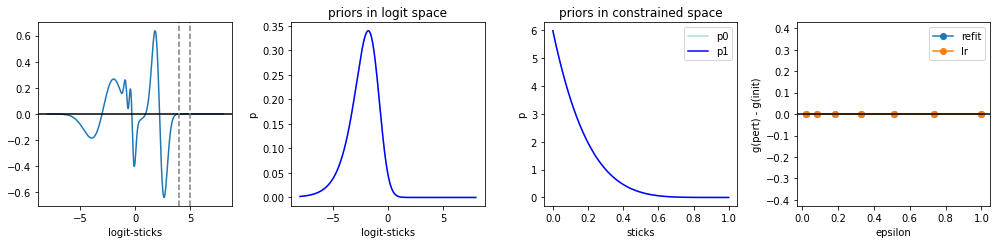

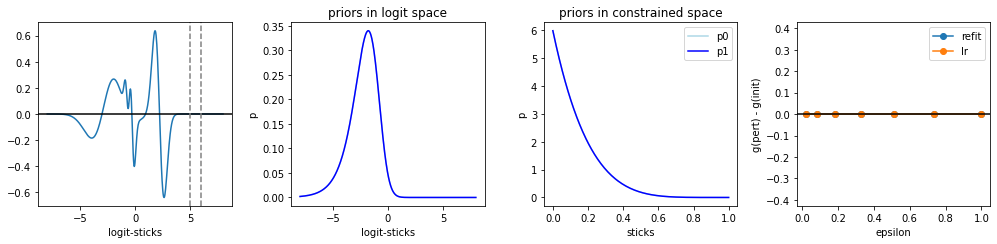

In [49]:
plot_results(get_n_clusters_pred,
                 ghess_num_clust_pred, 
                 infl_x_prior_num_clust_pred)


/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 1.613749e-02
  warnings.warn(
/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 5.602147e-02
  warnings.warn(
/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 6.110584e-02
  warnings.warn(
/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 2.922261e-01
  warnings.warn(
/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter 

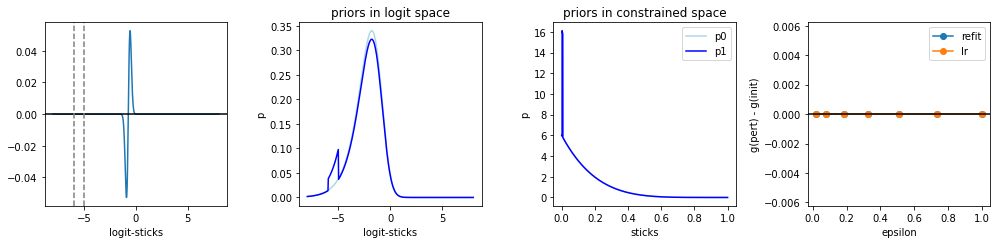

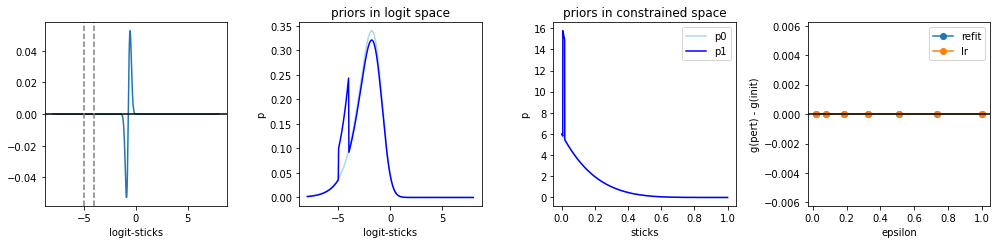

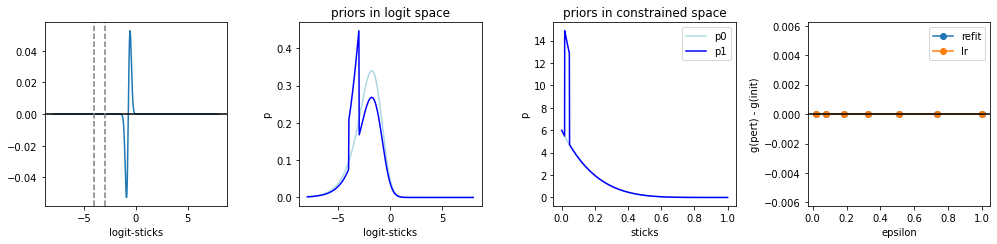

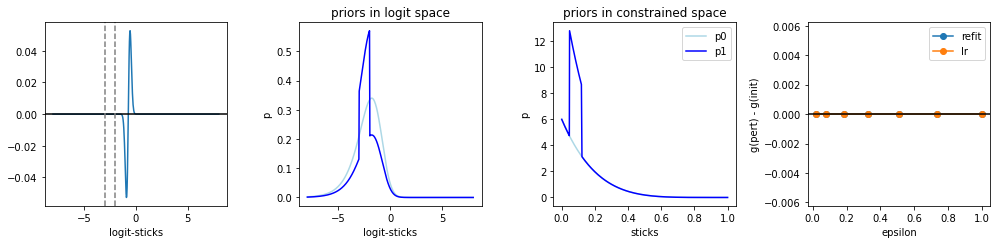

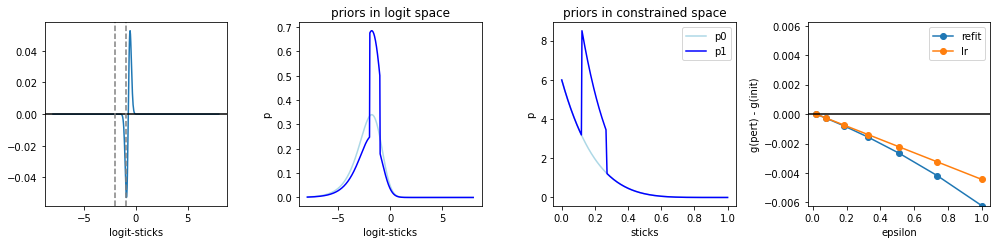

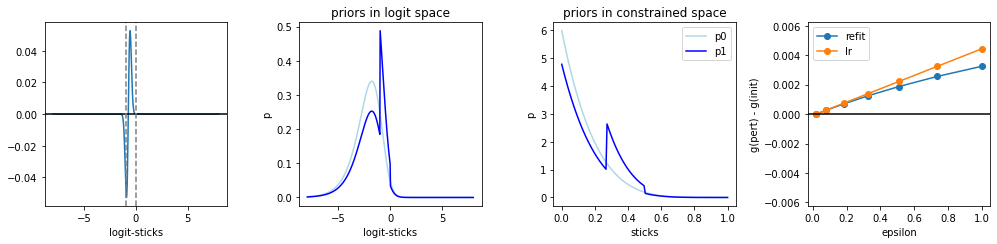

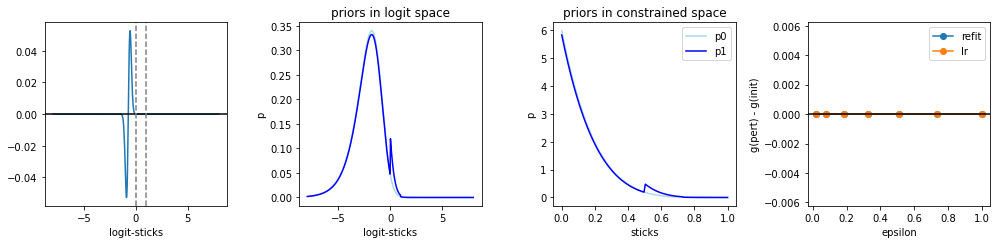

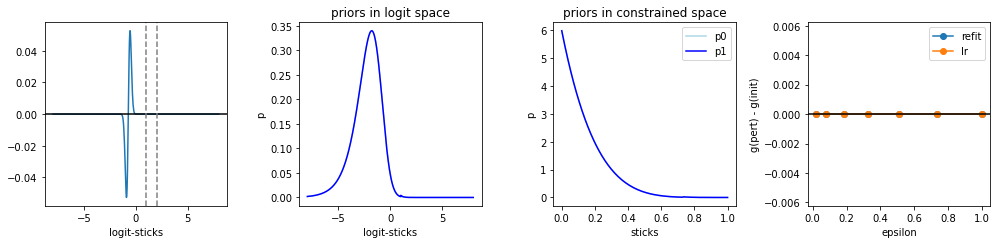

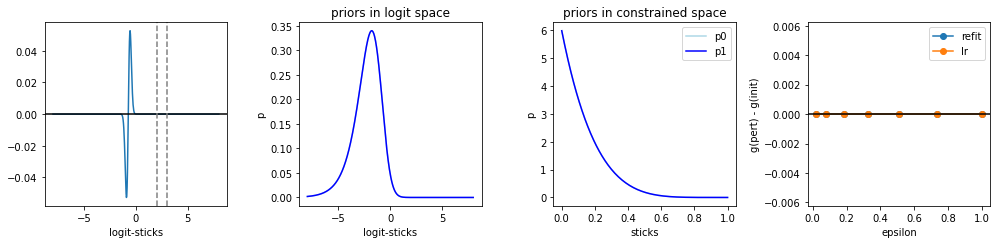

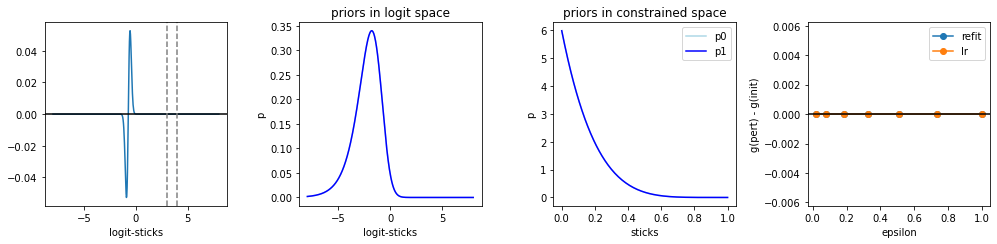

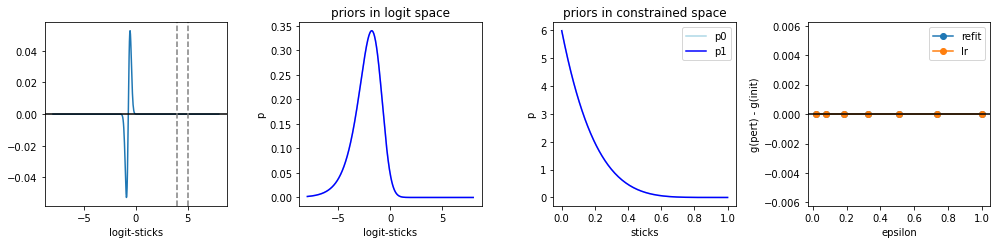

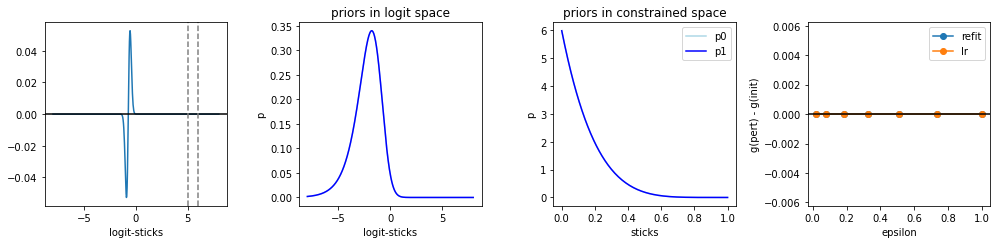

In [50]:
k = 0

plot_results(lambda x : get_mixture_weight_k(x, k), 
                     e_num_ind_results['ghess{}'.format(k)], 
                     e_num_ind_results['influence_grid_x_prior{}'.format(k)])
